# ISS AI Docking Locator and Distance Regressor Project

Neil Ghugare, Nishanth Kunchala, Pranav Moola, and Jacob Balek

### Imports and Data Fetching

In [4]:
import os
import random
import json
import pickle

import tensorflow as tf
import kagglehub as kh
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

We set a random seed to ensure reproducible results with Tensorflow randomization.

In [5]:
tf.random.set_seed(42)

We fetch the data using KaggleAPI and then read it into a Pandas DataFrame.

In [6]:
path = kh.dataset_download("msafi04/iss-docking-dataset")
# path = "/Users/rajkunchala/Documents/GitHub/HackAI2025/Rotated_Data/"
print(path)

/Users/rajkunchala/.cache/kagglehub/datasets/msafi04/iss-docking-dataset/versions/1


In [7]:
df = pd.read_csv(os.path.join(path, 'train.csv'))

In [5]:
df.head()

,ImageID,distance,location
0,0,351,"[215, 158]"
1,1,372,"[228, 269]"
2,2,488,"[255, 386]"
3,3,308,"[306, 426]"
4,4,67,"[248, 338]"


In [8]:
n_imgs = len(df)
n_imgs

10000

Below is a histogram of the distance values from the data. It is roughly uniform, but there are less data points for smaller distances.

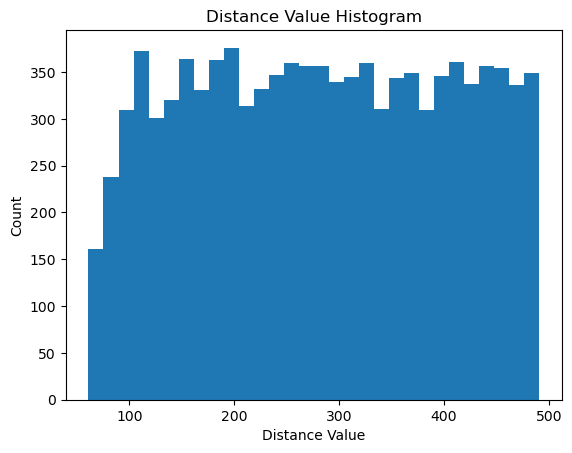

In [9]:
plt.hist(df['distance'], bins=30)
plt.xlabel('Distance Value')
plt.ylabel('Count')
plt.title('Distance Value Histogram')
plt.show()

To visualize the location data, we make a 2D heat map. 

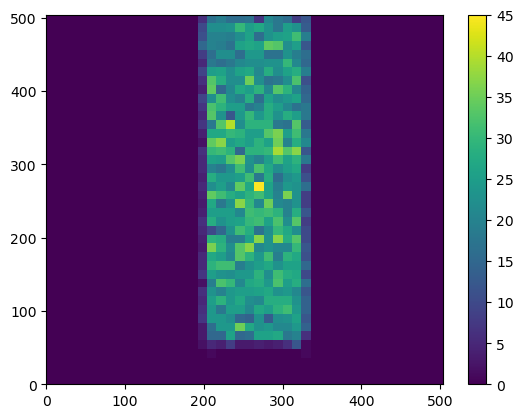

In [10]:
locations = tuple(map(lambda x: tuple(json.loads(x)), df['location']))
locations = np.array(locations)
x, y = locations[:,0], locations[:, 1]

plt.hist2d(x,y, bins=[np.arange(0, 512, 12),np.arange(0, 512, 12)])
plt.colorbar()
plt.show()

We repeat the same thing in three dimensions to see the data a bit better.

In [11]:
img_width = img_height = 512
batch_size = 32

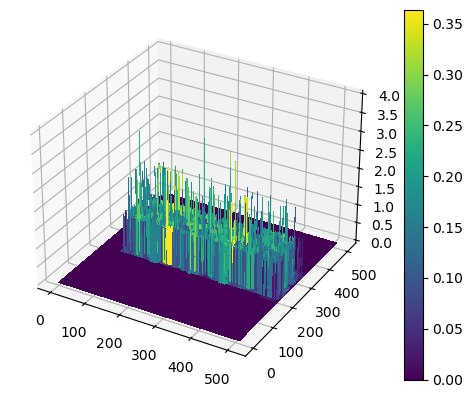

In [12]:
x = np.arange(0, img_width, 1)
y = np.arange(0, img_height, 1)

x, y = np.meshgrid(x, y)
z = np.zeros(x.shape)

for _ in df['location']:
    coord = tuple(json.loads(_))
    z[coord[0]][coord[1]] += 1

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(x, y, z, cmap='viridis',
                       linewidth=0, antialiased=False)
fig.colorbar(surf)
plt.show()


In [13]:
del x, y, z, locations

### Data Preparation

We get the image paths in the local directory and ensure that the length of this list equals the total sample size of the dataset (10,000). We then isolate the distance and location columns in the DataFrame.

In [14]:
image_paths = []
for f in os.listdir(os.path.join(path, 'train')):
    if f.startswith('.') or '.jpg' not in f:
        continue
    image_paths.append(os.path.join(path, 'train', f))
len(image_paths)

10000

In [15]:
distances = df.get('distance').tolist()
locations = df.get('location').tolist()

distances[:5]

[351, 372, 488, 308, 67]

Then we sort the image paths so that way all the images are in order from 0-9999.

In [16]:
image_paths.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))

We zip the paths and distances and the paths with locations. We then shuffle both of the zips with the same random seed, so that way each image still matches with its distance and location value. This also allows for reproducable results in the model later. After shuffling, we unzip to retrieve the lists once again.

In [17]:
combined_distances = list(zip(image_paths, distances))
combined_locations = list(zip(image_paths, locations))
random.Random(42).shuffle(combined_distances)
random.Random(42).shuffle(combined_locations)

In [18]:
image_paths_distances, distances = zip(*combined_distances)
image_paths_locations, locations = zip(*combined_locations)

We choose a 70-10-20 training, validation, and test split for the data.

In [19]:
train_split = int(0.7*n_imgs)
val_split = train_split + int(0.1*n_imgs)
test_split = val_split + int(0.2*n_imgs)
print(train_split, val_split, test_split)

7000 8000 10000


We then get the train image paths for the distances and locations and then get the train distances and locations. We repeat this for test and validation sets. The image paths for distances and locations will actually be exactly the same due to the prior random seeding, so we only need one for future use.

In [20]:
train_image_paths_distances = np.array(image_paths_distances[:train_split]).flatten()
train_distances = np.array(distances[:train_split]).flatten()
train_image_paths_locations = np.array(image_paths_locations[:train_split]).flatten()
train_locations = locations[:train_split]

val_image_paths_distances = np.array(image_paths_distances[train_split:val_split]).flatten()
val_distances = np.array(distances[train_split:val_split]).flatten()
val_image_paths_locations = np.array(image_paths_locations[train_split:val_split]).flatten()
val_locations = locations[train_split:val_split]

test_image_paths_distances = np.array(image_paths_distances[val_split:test_split]).flatten()
test_distances = np.array(distances[val_split:test_split]).flatten()
test_image_paths_locations = np.array(image_paths_locations[val_split:test_split]).flatten()
test_locations = locations[val_split:test_split]

We normalize the location values from [0, 512] to [0, 1] by simply dividing by 512. We can do it this simply since the image is square of size 512x512.

In [21]:
train_locations = tuple(map(lambda x: tuple(json.loads(x)), train_locations))
train_locations = np.array(train_locations)/512

val_locations = tuple(map(lambda x: tuple(json.loads(x)), val_locations))
val_locations = np.array(val_locations)/512

test_locations = tuple(map(lambda x: tuple(json.loads(x)), test_locations))
test_locations = np.array(test_locations)/512

We do the same for the distances, reshaping the data to [0, 1].

In [22]:
max_distance = np.max(distances)
min_distance = np.min(distances)
print(min_distance, max_distance)

train_distances = (train_distances-min_distance)/(max_distance-min_distance)
val_distances = (val_distances-min_distance)/(max_distance-min_distance)
test_distances = (test_distances-min_distance)/(max_distance-min_distance)

61 491


In [21]:
print(np.max(train_locations))
print(np.min(train_locations))

0.99609375
0.09375


In [22]:
print(np.max(train_distances))
print(np.min(train_distances))

1.0
0.0


We define a function `as_image` that reads the image path as an array, and reads in the RGB values. Then the RGB values are normalized to [0, 1] by dividing by 255. The processed image is returned. We apply this to the image paths lists.

In [23]:
def as_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (img_height, img_width))
    image = tf.image.convert_image_dtype(image, tf.float32) / 255.0
    return image

In [24]:
def create_dataset(paths, dists, locs):
    dataset = tf.data.Dataset.from_tensor_slices((paths, dists, locs))
    dataset = dataset.map(lambda i, d, xy: (as_image(i), {'distance': d, 'x': xy[0], 'y': xy[1]}), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.cache()
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

train_dataset = create_dataset(train_image_paths_distances, train_distances, train_locations)
val_dataset = create_dataset(val_image_paths_distances, val_distances, val_locations)
test_dataset = create_dataset(test_image_paths_distances, test_distances, test_locations)

### Model

We choose `MobileNetV3Small` for fine-tuning of our multi-headed network (MHN). We chose this model in order to use its strong convolutional power while saving computational time and resources (as models like `VGG16` or `ResNet` architecture are bigger). We freeze this model, making it not trainable. We use the default `imagenet` weights and we choose not to include the top layer so we can build our MHN on it.

In [25]:
net = tf.keras.applications.MobileNetV3Small(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)
net.trainable = False

/opt/miniconda3/envs/hai/lib/python3.11/site-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


In [26]:
# If this is commented out, it is to reduce file length as this output is long
# net.summary()

We create our MHN using Tensorflow's functional API. We set a learning rate and epochs and flatten the output of the net. We then define the three regression heads and create the model using those outputs. We use MAE for the error and loss for all heads, and weight the losses based on experimental trials. We use the `Adam` optimizer.

In [27]:
lr = 1e-4
epochs = 50

flatten = net.output
flatten = tf.keras.layers.Flatten()(flatten)

regression = tf.keras.layers.Dense(16, activation='elu')(flatten)
# regression = tf.keras.layers.Dense(32, activation='elu')(regression)

# DISTANCE REGRESSION
# left_head = tf.keras.layers.Dense(16, activation='elu')(regression)
left_head = tf.keras.layers.Dense(8, activation='elu')(regression)
left_head = tf.keras.layers.Dense(1, activation='elu', name='distance')(left_head)

# LOCATION X REGRESSION
# middle_head = tf.keras.layers.Dense(8, activation='elu')(regression)
middle_head = tf.keras.layers.Dense(1, activation='elu', name='x')(regression)

# LOCATION Y REGRESSION
# right_head = tf.keras.layers.Dense(16, activation='elu')(regression)
right_head = tf.keras.layers.Dense(8, activation='elu')(regression)
right_head = tf.keras.layers.Dense(1, activation='elu', name='y')(right_head)

model = tf.keras.Model(inputs=net.input, outputs=(left_head, middle_head, right_head))

losses = { 'distance': 'mean_absolute_error', 'x': 'mean_absolute_error', 'y': 'mean_absolute_error' }
loss_weights = { 'distance': 0.4, 'x': 0.2, 'y': 0.4 }

opt = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(loss=losses, optimizer=opt, loss_weights=loss_weights)

# If this is commented out, it is to reduce file length as this output is long
# print(model.summary())

We define the train, test, and validation targets. We use `EarlyStopping` monitoring validation loss and `ModelCheckpoint` saving the best model also based on validation loss as callbacks. We then fit the model.

In [28]:
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",  # Reduce when val_loss stops improving
    factor=0.1,         # Halve learning rate
    patience=2,          # Wait 2 epochs before reducing
    min_lr=1e-7,         # Minimum learning rate
    min_delta=1e-5,      # Minimum delta needed to trigger ReduceLROnPlateau()
    verbose=1
)

In [29]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
             tf.keras.callbacks.ModelCheckpoint(filepath='model.keras', monitor='val_loss', save_best_only=True),
             lr_schedule]
print(train_dataset)
history = model.fit(train_dataset,
                    validation_data = val_dataset,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks=callbacks)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), {'distance': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'x': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'y': TensorSpec(shape=(None,), dtype=tf.float64, name=None)})>
Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 135s 604ms/step - distance_loss: 0.2091 - loss: 0.6871 - x_loss: 0.3601 - y_loss: 0.1178 - val_distance_loss: 0.0830 - val_loss: 0.4306 - val_x_loss: 0.3037 - val_y_loss: 0.0441 - learning_rate: 1.0000e-04
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 124s 568ms/step - distance_loss: 0.0756 - loss: 0.4143 - x_loss: 0.3032 - y_loss: 0.0354 - val_distance_loss: 0.0648 - val_loss: 0.4114 - val_x_loss: 0.3033 - val_y_loss: 0.0434 - learning_rate: 1.0000e-04
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 125s 571ms/step - distance_loss: 0.0582 - loss: 0.3923 - x_loss: 0.3028 - y_loss: 0.0314 - val_distance_loss: 0.0600 - val_loss: 0.3890 - val_x_loss: 0.3025 - val_y_loss: 0.02

### Best Model Loss Table

| Dataset | Total Loss | Distance Loss | X Loss | Y Loss |
|---------|------------|--------------|--------|--------|
| Train   | 0.0518     | 0.0411       | 0.0086 | 0.0458 |
| Test    | 0.0574     | 0.0454       | 0.0095 | 0.0500 |

### Analysis

We plot the model loss per epoch, the distance loss per epoch, the x-coordinate loss per epoch, and the y-coordinate loss per epoch.

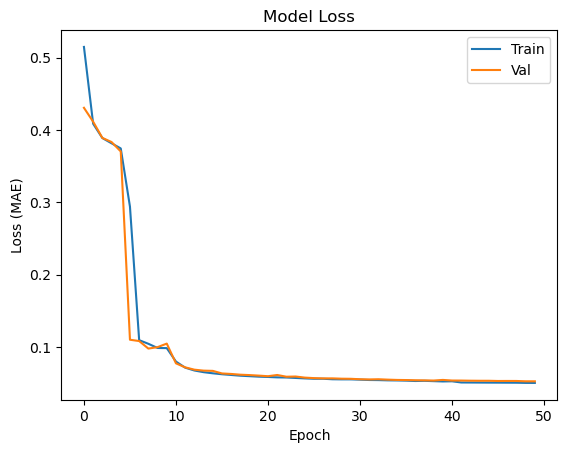

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss (MAE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.savefig('loss5.png')
plt.show()

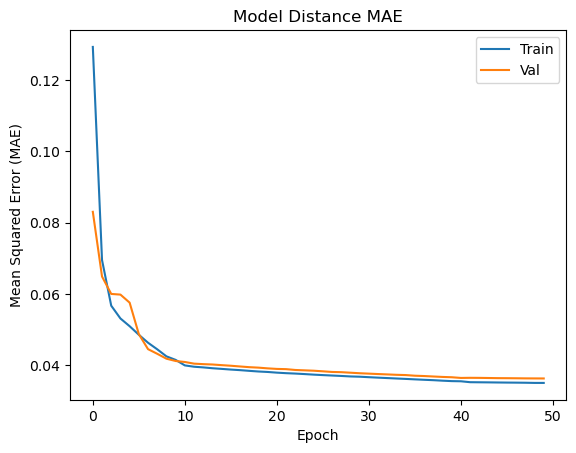

In [31]:
plt.plot(history.history['distance_loss'])
plt.plot(history.history['val_distance_loss'])
plt.title('Model Distance MAE')
plt.ylabel('Mean Squared Error (MAE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.savefig('distancemae5.png')
plt.show()

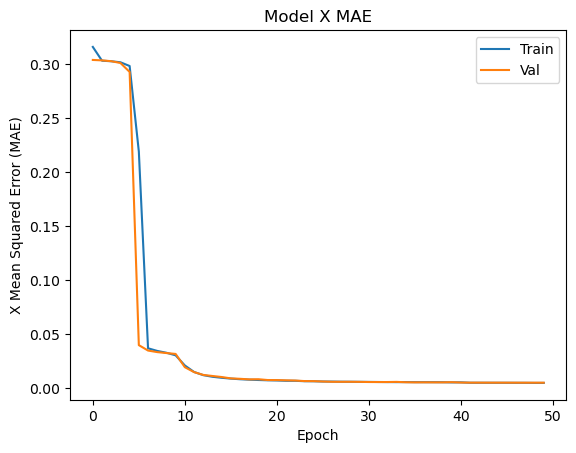

In [32]:
plt.plot(history.history['x_loss'])
plt.plot(history.history['val_x_loss'])
plt.title('Model X MAE')
plt.ylabel('X Mean Squared Error (MAE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.savefig('xmae5.png')
plt.show()

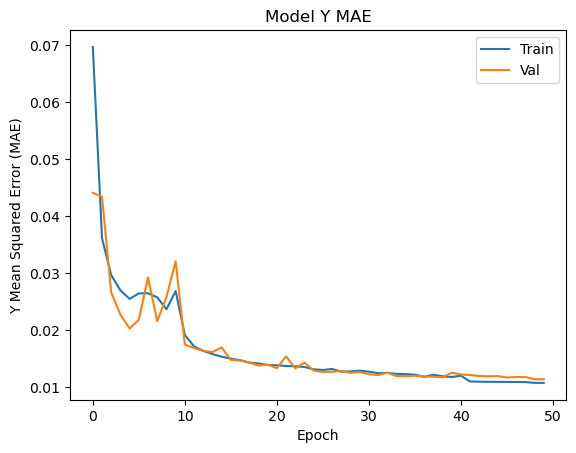

In [33]:
plt.plot(history.history['y_loss'])
plt.plot(history.history['val_y_loss'])
plt.title('Model Y MAE')
plt.ylabel('Y Mean Squared Error (MAE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.savefig('ymae5.png')
plt.show()

We evaluate the *latest* model on the test set, just to get a preliminary feel. We also make predictions on the test set.

In [ ]:
model.evaluate(test_dataset)

In [ ]:
predictions = model.predict(test_dataset)

63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step


The following code snippet plots the spread in guess locations for the predictions, test set, and train set.

(2000,)
(2000,)


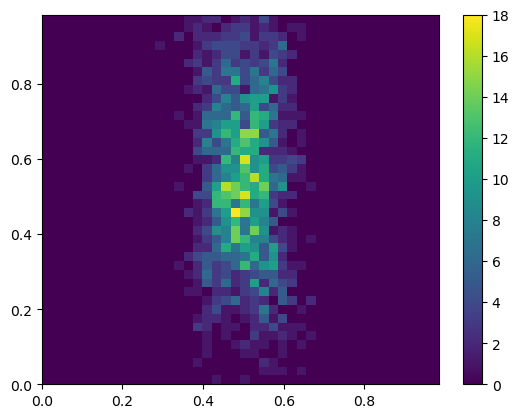

[[0.50390625 0.41796875]
 [0.50390625 0.21679688]
 [0.52539062 0.28710938]
 [0.49609375 0.8359375 ]
 [0.51757812 0.78125   ]]
2000


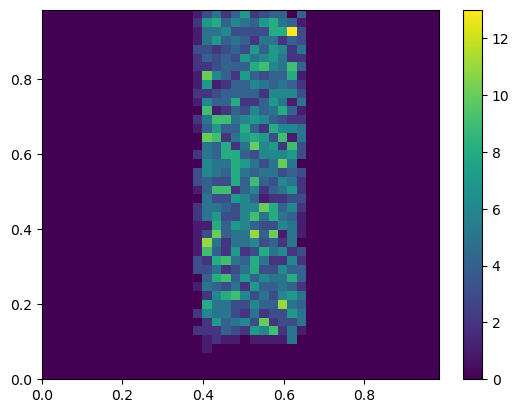

7000


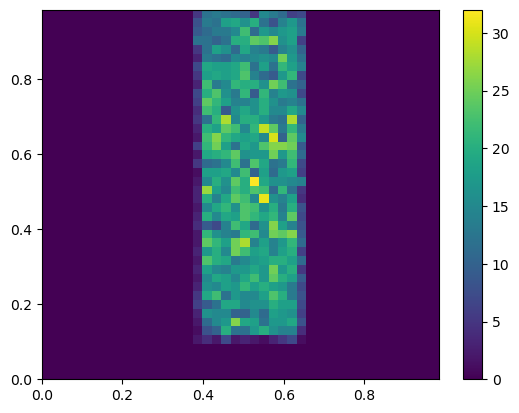

In [ ]:
locations = predictions[1:3]
x, y = np.array(locations[0]).flatten(), np.array(locations[1]).flatten()
print(np.array(x).shape)
print(np.array(y).shape)
plt.hist2d(x,y, bins=[np.arange(0, 1,12/512),np.arange(0, 1,12/512)])
plt.colorbar()
plt.show()

print(train_locations[:5])

locations = np.array(test_locations)
x, y = locations[:,0], locations[:, 1]

print(len(x))

plt.hist2d(x,y, bins=[np.arange(0, 1,12/512),np.arange(0, 1,12/512)])
plt.colorbar()
plt.show()

locations = np.array(train_locations)
x, y = locations[:,0], locations[:, 1]

print(len(x))

plt.hist2d(x,y, bins=[np.arange(0, 1,12/512),np.arange(0, 1,12/512)])
plt.colorbar()
plt.show()

Now we perform the same analysis on the *best* model.

In [27]:
best_model = tf.keras.models.load_model('model.keras')
predictions = best_model.predict(test_dataset)

63/63 ━━━━━━━━━━━━━━━━━━━━ 52s 817ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 51s 794ms/step - distance_loss: 0.0368 - loss: 0.0543 - x_loss: 0.0051 - y_loss: 0.0124


[0.05332646518945694,
 0.03625882789492607,
 0.005041720345616341,
 0.012036167085170746]

### Best Model Loss Table

| Dataset | Total Loss | Distance Loss | X Loss | Y Loss |
|---------|------------|--------------|--------|--------|
| Train   | 0.0518     | 0.0411       | 0.0086 | 0.0458 |
| Test    | 0.0574     | 0.0454       | 0.0095 | 0.0500 |

(2000,)
(2000,)


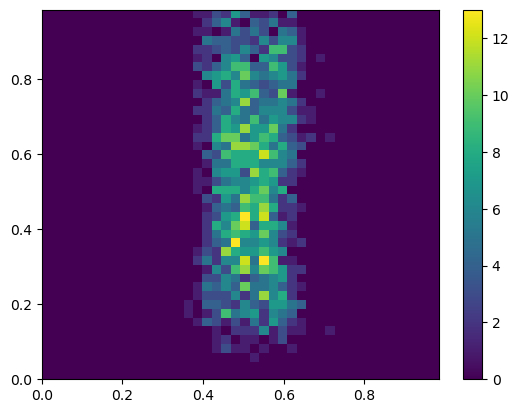

[[0.50390625 0.41796875]
 [0.50390625 0.21679688]
 [0.52539062 0.28710938]
 [0.49609375 0.8359375 ]
 [0.51757812 0.78125   ]]
2000


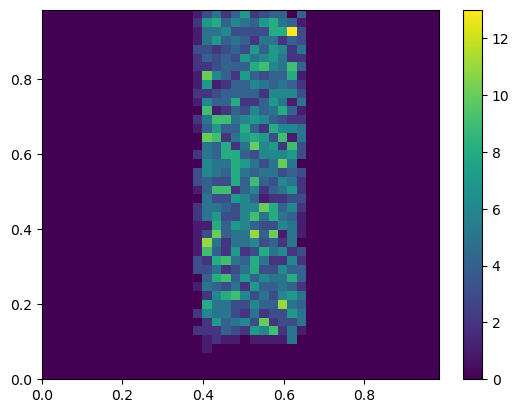

7000


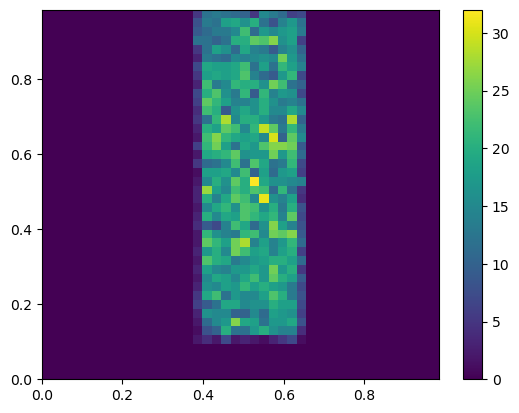

In [28]:
locations = predictions[1:3]
x, y = np.array(locations[0]).flatten(), np.array(locations[1]).flatten()
print(np.array(x).shape)
print(np.array(y).shape)
plt.hist2d(x,y, bins=[np.arange(0, 1,12/512),np.arange(0, 1,12/512)])
plt.colorbar()
plt.show()

print(train_locations[:5])

locations = np.array(test_locations)
x, y = locations[:,0], locations[:, 1]

print(len(x))

plt.hist2d(x,y, bins=[np.arange(0, 1,12/512),np.arange(0, 1,12/512)])
plt.colorbar()
plt.show()

locations = np.array(train_locations)
x, y = locations[:,0], locations[:, 1]

print(len(x))

plt.hist2d(x,y, bins=[np.arange(0, 1,12/512),np.arange(0, 1,12/512)])
plt.colorbar()
plt.show()

In [ ]:
best_model.evaluate(test_dataset)

63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 160ms/step - distance_loss: 0.0454 - loss: 0.0574 - x_loss: 0.0095 - y_loss: 0.0025


[0.05636940151453018,
 0.044484611600637436,
 0.009464392438530922,
 0.002384910825639963]